# Lab 5 - Kernel Regularized Least Squares

In this lab activity we consider the extension of regularized least squares to non-linear problems using kernel functions.

A brief summary of the tasks:
 1. Generate a simple non-linear data-set
 2. Use **linear** RLS to try and learn with such dataset
 3. Use a **feature transformation** for learning with non-linear data
 4. Implement various kernel functions
 5. Implement kernel RLS
 6. Generate a more complex non-linear data-set
 7. Use kernel RLS for learning on non-linear data, use cross-validation to find the best hyperparameters.

In [467]:
%matplotlib inline
import numpy as np
import matplotlib as cm
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.spatial
import os

In [468]:
def calc_err(Ypred, Ytrue):
    return np.mean((Ypred-Ytrue)**2)

# Part 1: Learning with a simple non-linear dataset

## Generate quadratic data

In this lab we are going to use regression datasets where the target `Y` is **not a linear function** of the inputs `X`.

As a first example, see the following function to generate quadratic data.

In [469]:
def quadratic_data_gen(n, w, sigma_noise):
    X = np.random.uniform(-3, 3, size=(n, 1))
    Xsq = X ** 2
    noise = np.random.normal(0, sigma_noise, size=(n, 1))

    # Here we can use scalar multiplication since in dimension 1
    Y = Xsq * w + noise
    
    return X, Y


Shape of x: (100, 1), shape of y: (100, 1)


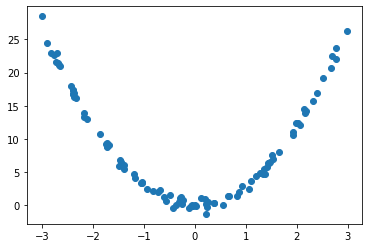

In [470]:
x_tr, y_tr = quadratic_data_gen(100, np.array([3]), 0.5)

print(f"Shape of x: {x_tr.shape}, shape of y: {y_tr.shape}")
fig, ax = plt.subplots()
ax.scatter(x_tr, y_tr);

## Task 1: Linear RLS

The implementation of linear regularized least-squares is given below in the functions `rls_train` and `rls_predict`. 

Remember: regularized least-squares has the following form

$$(X_{tr}^\top X_{tr} + \lambda n I)w = X_{tr}^\top Y_{tr}$$


Tasks:
 - Use RLS to train a linear regressor for the quadratic data. Comment on the results.

In [471]:
def rls_train(x, y, reg_par):
    cov = x.T @ x + reg_par * x.shape[0] * np.eye(x.shape[1])
    rhs = x.T @ y
    w = np.linalg.solve(cov, rhs)
    return w

def rls_predict(x, w):
    return x @ w

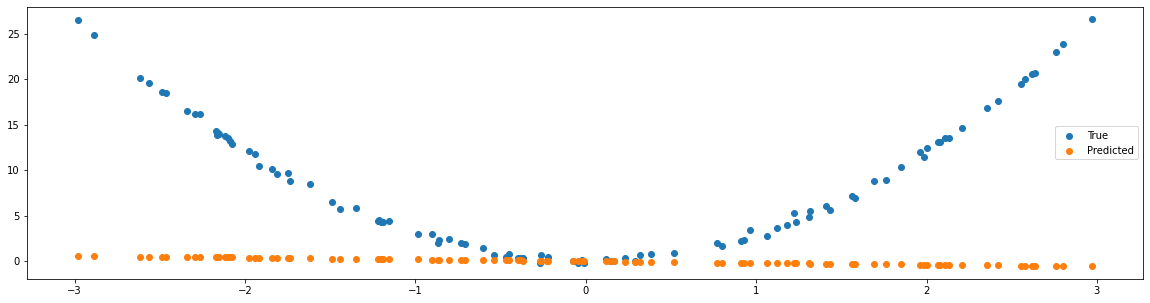

In [472]:
x_tr, y_tr = quadratic_data_gen(100, np.array([3]), 0.3)

fig, ax = plt.subplots()
fig.set_size_inches(20,5)


        
reg_par = np.random.rand(1)
pred_tr = rls_predict(x_tr, rls_train(x_tr, y_tr, reg_par=reg_par ))        

ax.scatter(x_tr, y_tr, label="True")
ax.scatter(x_tr, pred_tr, label="Predicted")
ax.legend(loc="best");

# Comments

---

Obviously and as expected, we fail to fit a quadratic looking function with a line! 

## Task 2: Feature transform

There is a simple way to use a linear algorithm for learning non-linear data: transforming the input data in such a way to convert the problem into a linear one.

This is a simple fix in some cases, but becomes cumbersome if the datasets are non-linear in a complex way.

Here we adopt this approach to train a RLS classifier with the quadratic dataset:
 1. Generate the quadratic dataset
 2. Transform the data so that it becomes a (n, 2) matrix containing the original input, and a transformed version of itself. Clearly the correct transformation depends on the underlying function (a quadratic function!).
 3. Use the RLS algorithm on the new dataset
 4. Plot **and comment** on the results

In [473]:
x_tr, y_tr = quadratic_data_gen(100, np.array([3]), 0.5)

# Instead of just the given xs build a feature matrix with the xs and their squares:
trsf_x_tr = np.concatenate([x_tr,x_tr**2], axis=1)
assert trsf_x_tr.shape == (x_tr.shape[0], 2), f"Shape of x_tr is {x_tr.shape}. Expected ({x_tr.shape[0]}, 2)"

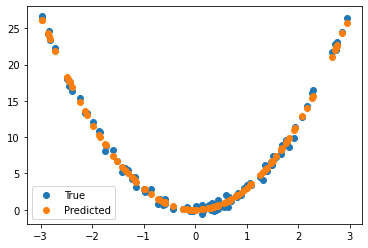

In [474]:
# Now train a linear regression function on the new data!
trsf_w_rls = rls_train(trsf_x_tr, y_tr, reg_par=0.1)
pred_tr = rls_predict(trsf_x_tr, trsf_w_rls)

fig, ax = plt.subplots()
ax.scatter(x_tr, y_tr, label="True")
ax.scatter(x_tr, pred_tr, label="Predicted")
ax.legend(loc="best");

## Comments:

---

Using a Feature Map, we can map our datapoints into a higher dimensional "hyper-plane". To fit a linear function in the forementioned higher dimensional space may result in a non-linear function in a lower dimensional space as demonstrated in the plot.

# Part 2: Kernel Least Squares

## Implement 3 types of kernel

The `kernel_matrix` function takes as input two arrays of data, and outputs the kernel matrix evaluated at every pair of points.

You should implement it using the formulas seen in class for the following kernels:
 - linear kernel -- here the `param` argument can be ignored
 - polynomial kernel -- here the `param` argument is the exponent of the kernel
 - gaussian kernel -- here the `param` argument is the kernel length-scale ($\sigma$)

In [475]:
def squared_distances(X1, X2):
    """Compute the matrix of pairwise squared-distances between all points in X1 and in X2.
    """
    return scipy.spatial.distance.cdist(X1, X2, metric='seuclidean')

In [476]:
def kernel_matrix(X1, X2, kernel_type, param):
    # X1 : array of shape n x d
    # X2 : array of shape m x d
    if kernel_type == 'linear':
        return X1 @ X2.T
    elif kernel_type == 'polynomial':
        return ((X1 @ X2.T) + 1) ** param
    elif kernel_type == 'gaussian':
        return np.exp(-squared_distances(X1,X2) / (2 * param**2))
    else:
        raise ValueError(kernel_type)

**Task:** Visualize the kernel (e.g. of the Gaussian type) for random data with different length-scales. What can you observe?

# Observations
----
- Kmatrix looks somehow symmetrical, maybe triangular decomposition comes handy?
- it has the same value whe i = j (i = row index, j = col index) using gaussian and linear methods
- playing with sigma with gaussian kernel matrix results in having more different values, low sigma it has few
- polynomial kernel have fewer and close colored mapped values than the linear 

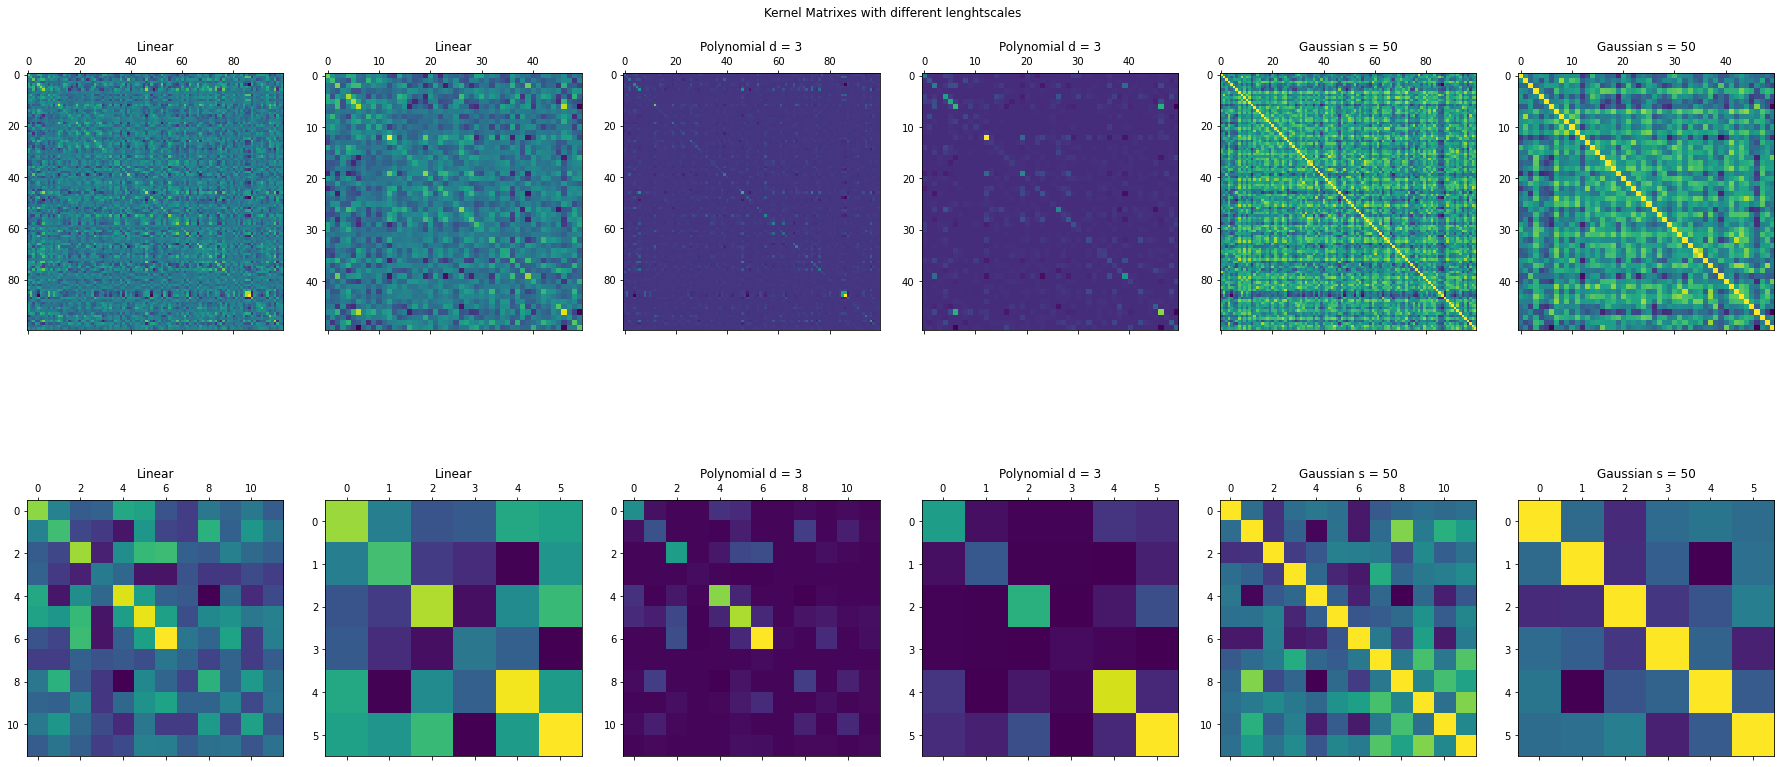

In [477]:
D = np.random.randn(100, 5)

lengthscale = 100

# given axes plots the matrix with 4 lenghts scales
def fancy_plot(ax, lengthscale, pos, K, title):
    n_rows = range(0, 2)
    n_cols = range(pos, pos+2)
    for i in n_rows:
        for j in n_cols:
            ax[i,j].matshow(K[:lengthscale // (i+1), :lengthscale // (i+1)])
            ax[i,j].set_title(title)
            lengthscale = lengthscale//2

fig, ax = plt.subplots(2,6)
fig.set_size_inches(25,12)
fig.tight_layout()
fig.suptitle("Kernel Matrixes with different lenghtscales")
K = kernel_matrix(D, D, "linear", 0)
fancy_plot (ax, 100, 0, K, f"Linear")

K = kernel_matrix(D, D, "polynomial",  3 )
fancy_plot (ax, 100, 2, K, f"Polynomial d = {3}")
sigma = 50
K = kernel_matrix(D, D, "gaussian", sigma)
fancy_plot (ax, 100, 4, K, f"Gaussian s = {sigma}")

## Implement Kernel RLS

Remember that, given kernel $K = k(x_i, x_j)$ for $i=(1, \dots, n)$ and $j=(1, \dots, n)$, KRLS learns a weight-vector with the following formula

$$(K + n \lambda I)w = Y$$

and then predictions on some new point $\tilde{x}$ are given by

$$f^{\mathrm{KRLS}}(\tilde{x}) = k(\tilde{x}, X^{\mathrm{train}}) w$$

In [478]:
def krls_train(x, y, reg_par, kernel_type, kernel_par):
    K_hat = kernel_matrix(x, x, kernel_type,  kernel_par )
    n,d = K_hat.shape
    a = K_hat + (reg_par * n * np.identity(n))
    w = np.linalg.solve(a, y) 
    return w

def krls_predict(x_ts, x_tr, w, kernel_type, kernel_par):
    return kernel_matrix(x_ts, x_tr, kernel_type, kernel_par) @ w

Now test the functions you have implemented on the quadratic dataset.

**Tasks:**
 1. use the linear kernel, can you fit the data?
 2. use the polynomial kernel, test the effect of the kernel parameter on the results:
    - describe what happens with a low/high exponent in terms of the bias-variance tradeoff.
 3. use the polynomial kernel, but fix the kernel parameter. Test the effect of the regularization parameter
    - describe what happens with a low/high regularizer in terms of the bias-variance tradeoff

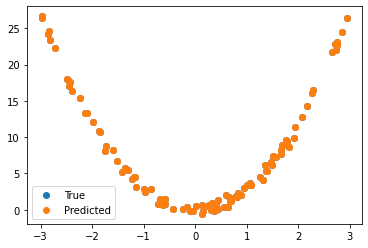

In [479]:


w_krls = krls_train(x_tr, y_tr, reg_par=0.000000001, kernel_type="gaussian", kernel_par=5)
pred_tr = krls_predict(x_tr, x_tr, w_krls, kernel_type="gaussian", kernel_par=5)
#
fig, ax = plt.subplots()
ax.scatter(x_tr, y_tr, label="True")
ax.scatter(x_tr, pred_tr, label="Predicted")
ax.legend(loc="best");

- We can fit the data using the gaussian kernel method, a vary low lambda (We trust the generated data!) and a sigma of 5 (25 sigma squared)
- playing around with the "knobs" as we choose higher lambdas, the model seems to generate a better fit because of the overfitting that is clearly visible.
- using polynomial kernel methods we could approximate the target. It looks somehow stable as shown in the following graphs

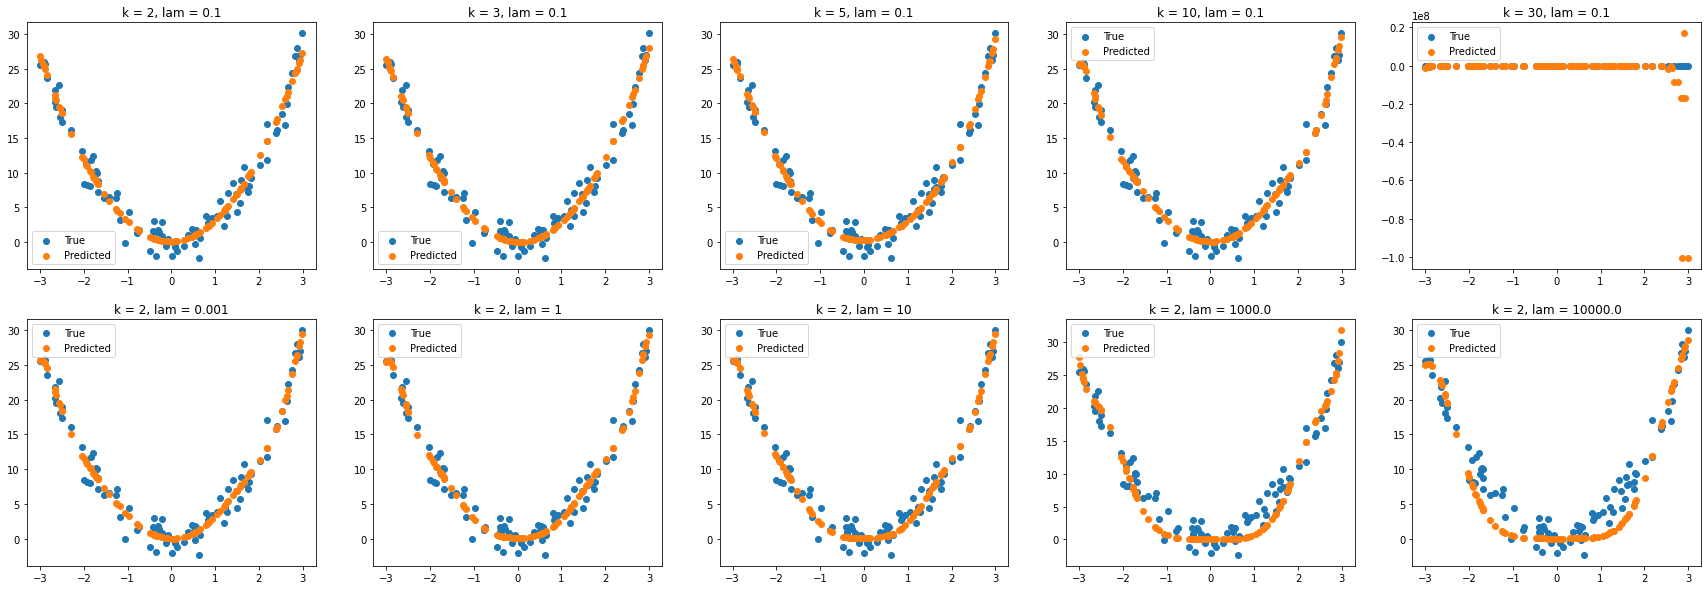

In [480]:
x_tr, y_tr = quadratic_data_gen(100, np.array([3]), 2.0)
ks = [2,3,5,10, 30] # checking with just one value
reg_par =[10e-4, 1, 10, 10e2, 10e3]

fig, ax = plt.subplots(2,5)
fig.set_size_inches(30, 10)

for i in range(len(ks)):
  w = krls_train(x_tr, y_tr, reg_par=0.1, kernel_type="polynomial", kernel_par=ks[i])
  pred_tr = krls_predict(x_tr, x_tr, w, kernel_type="polynomial", kernel_par=ks[i])
  ax[0,i].scatter(x_tr, y_tr, label="True")
  ax[0,i].scatter(x_tr, pred_tr, label="Predicted")
  ax[0,i].legend(loc="best")
  ax[0,i].set_title(f"k = {ks[i]}, lam = {0.1}")


for j in range(len(reg_par)):
  w = krls_train(x_tr, y_tr, reg_par=reg_par[j], kernel_type="polynomial", kernel_par=10)
  pred_tr = krls_predict(x_tr, x_tr, w, kernel_type="polynomial", kernel_par=10)
  ax[1,j].scatter(x_tr, y_tr, label="True")
  ax[1,j].scatter(x_tr, pred_tr, label="Predicted")
  ax[1,j].legend(loc="best")
  ax[1,j].set_title(f"k = {2}, lam = {reg_par[j]}")


# Some Thoughts - Bias Variance... Overfitting and Underfitting
---

- the regularization allows us to not trust too much our data when it comes to perform a regression
- as the exponent grows I dont'see too much effect until it explode (k = 30 for instance), of course the higher grade the higher the instability and the variance.
  
- the higher than 2 exponent dont add to this problem much information.
- the regularizier if high it introduces a bias, that can lead to higher error on training sets although working way better on new data.

- it is fundamental to choose wisely the sweet spot where the variance of higer exponents meets the bias introduced by the regularizer

## Generating a more complex non-linear dataset

Define a function to generate a d-dimensional synthetic dataset where the targets `Y` depend non-linearly on the variables `X`.

The parameters of the function are:
 - n : the number of samples
 - d : the dimension of the samples
 - low_d : the lower-bound for the uniformly distributed samples
 - high_d : the higher-bound for the uniformly distributed samples
 - sigma_noise : standard deviation of Gaussian noise added to the targets
 
It should return:
 - X : 2D array of size n, d which fits in the desired bounds
 - Y : 2D array of size n, 1 which is a non-linear function of `X` (and a linear function of `w`)
 
Examples of non-linear regression functions:
 - polynomial dependence of the Y on the X data
 - logarithmic dependence
 - more complex transforms (e.g. trig functions)


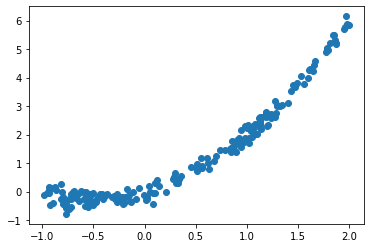

In [481]:
def nonlinear_data_gen(n, d, low_d, high_d, sigma_noise):
    X = np.random.uniform(low=low_d, high=high_d, size=(n, d))
    assert X.shape == (n, d), "Shape of X incorrect"
    
    Y = X**2 + X
    # Y = np.random.uniform(low=low_d, high=high_d, size=(n, 1))
    Y = np.resize(Y,(n,1))
    assert Y.shape == (n, 1), "Shape of Y incorrect"
    
    # Add noise

    noise = np.random.normal(0, sigma_noise, size=(n, 1))
    Y_noisy = Y + noise 
    
    # Y_noisy = np.concatenate([Y,noise], axis=1)
    return X, Y_noisy

n=200
d=1
low_d = -1
high_d = 2
sigma_noise = 0.2
x,y = nonlinear_data_gen(n, d, low_d, high_d, sigma_noise)

plt.scatter(x, y)


## KRLS and cross-validation
Now we will use KRLS and k-fold CV to learn on the complex non-linear datasets we have generated.

In this last part you will have to do the following:
 1. Implement a function called `krls_kfoldcv` to select the best regularization parameter **and** kernel parameter with k-fold cross-validation. Your life will be easier if you use the provided `krls_kfold_valerr` function.
 2. Generate a non-linear dataset, find the best hyperparameters (using e.g. the Gaussian kernel) with the training set, and then use them to make predictions on the test-set. Are you able to fit your data well?
 3. Analyse how the amount of noise (see the `sigma_noise` parameter of `nonlinear_data_gen`) influences the best lambda as selected by cross-validation. In particular answer to the following question:
     - How does the best lambda change as you increase/decrease the amount of noise in your dataset? Why? 
     
    **Hint: keep the kernel parameter fixed for this third task, otherwise it might be very hard to see**

In [482]:
def krls_kfold_valerr(x_tr, y_tr, num_folds, reg_par, kernel_type, kernel_par):
    """
    Compute the k-fold cross-validation error for one KRLS model (with speficied regularization, 
    kernel and kernel parameter).
    
    This function returns both the training errors and the validation errors 
    obtained from CV (as numpy arrays).
    """
    if num_folds <= 1:
        raise Exception("Please supply a number of folds > 1")

    n_tot = x_tr.shape[0]
    
    n_val = int(n_tot // num_folds)
    
    tr_errs, val_errs = [], []
    # `split_idx`: a list of arrays, each containing the validation indices for 1 fold
    rand_idx = np.random.choice(n_tot, size=n_tot, replace=False)
    split_idx = np.array_split(rand_idx, num_folds)
    for fold in range(num_folds):
        # Set the indices in boolean mask for all validation samples to `True`
        val_mask = np.zeros(n_tot, dtype=bool)
        val_mask[split_idx[fold]] = True
        
        kf_x_tr = x_tr[~val_mask]
        kf_y_tr = y_tr[~val_mask]
        kf_x_val = x_tr[val_mask]
        kf_y_val = y_tr[val_mask]
        
        w_krls = krls_train(kf_x_tr, kf_y_tr, reg_par=reg_par, kernel_type=kernel_type, kernel_par=kernel_par)
        pred_tr = krls_predict(kf_x_tr, kf_x_tr, w_krls, kernel_type=kernel_type, kernel_par=kernel_par)
        pred_val = krls_predict(kf_x_val, kf_x_tr, w_krls, kernel_type=kernel_type, kernel_par=kernel_par)
        tr_errs.append(calc_err(pred_tr, kf_y_tr))
        val_errs.append(calc_err(pred_val, kf_y_val))
    return np.asarray(tr_errs), np.asarray(val_errs)




In [483]:
def krls_kfoldcv(x_tr, y_tr, num_folds, reg_par_list, kernel_type, kernel_par_list):
    """Choose the best parameters for both the regularizer and the kernel parameter according to K-Fold CV.
    """
    r = len(reg_par_list)
    k = len(kernel_par_list)

    # we will need some (lazy) lists to avoid using messy index
    lambdas     =   []
    Kerpars     =   []
    tr_err      =   []
    val_err     =   []

    ## search space #####
    for i, reg_par in enumerate(reg_par_list):
        for j, kernel_par in enumerate(kernel_par_list):

            # memorizing reg_par - kerner_par tuple  with same idx  
            lambdas.append(reg_par)
            Kerpars.append(kernel_par)

            # Kfolding
            tr_errs_list, val_errs_list = krls_kfold_valerr(x_tr, y_tr, num_folds, reg_par, kernel_type, kernel_par)

            # appending the means of the lists
            tr_err.append( np.mean(tr_errs_list))
            val_err.append( np.mean(val_errs_list))

    ## get the right index ##           
    best  =   np.argmin(np.asarray(val_err))
    
    #plt.matshow(val_err)
    
    # best params are served
    best_reg_par    = lambdas[best]
    best_kernel_par = Kerpars[best]
    best_err        = val_err[best]
    
    # info!
    print(f"The best error (MSE={best_err}) was obtained with "
          f"lambda={best_reg_par}, kernel-parameter={best_kernel_par}")

    # returning best parameters
    return best_reg_par, best_kernel_par, best_err

In [484]:
# proof of concept ignorare!!!!


values = np.array([
    [8,2,3,4,5,6],
    [3,6,6,7,2,6],
    [3,8,5,1,2,9],
    [6,4,2,7,8,3]
    ])

values.min()          # = 1
np.min(values)        # = 1
np.amin(values)       # = 1
min(values.flatten()) # = 1
np.unravel_index(np.argmin(values), values.shape)

(2, 3)

In [485]:
n           = 200
d           =  1
low_d       =  0
high_d      =  1
sigma_noise = .1
num_folds   =  6

reg_par_list    =    np.arange(10e-1,10,10e-1)
ker_list        =    np.arange(1, 10     , 1)

x_tr, y_tr = nonlinear_data_gen(n, d, low_d, high_d, sigma_noise)
x_ts, y_ts = nonlinear_data_gen(n, d, low_d, high_d, sigma_noise)

# getting hyperparams
LAM, KER, ERR = krls_kfoldcv(x_tr, y_tr, num_folds, reg_par_list, "polynomial", ker_list)

# Now retrain on the whole of x_tr with the best parameters and test on x_ts!
W = krls_train(x_tr, y_tr , reg_par=LAM, kernel_type="polynomial", kernel_par=KER)

#predict using xts
pred_ts = krls_predict(x_tr, x_ts, W, kernel_type="polynomial", kernel_par=KER) 

print("err" , calc_err(pred_ts, y_ts))

The best error (MSE=0.025414566687879576) was obtained with lambda=1.0, kernel-parameter=9
err 3.6815036887563632


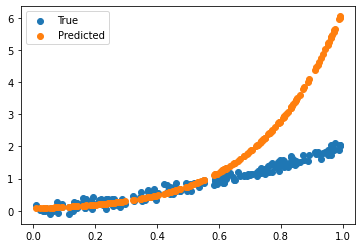

In [486]:


fig, ax = plt.subplots()
ax.scatter(x_tr, y_tr, label="True")
ax.scatter(x_tr, pred_ts, label="Predicted")
ax.legend(loc="best");

#LAM, KER, ERR = krls_kfoldcv(x_tr, y_tr, num_folds, reg_par_list, "polynomial", ker_list)


In [488]:
# TODO: Analyse the effect of noise!
n = 200
d = 1
low_d = -100
high_d = 100
num_folds = 5

sigmas = np.arange(0.1, 100,1)
lambdas = np.arange(0, 0.5, 0.01)
#fixing KERNEL PARAM
KER = 9

# making noise
noises = [np.random.normal(0, sigma, size=(n, 1)) for sigma in sigmas]


best_lambdas = []

for s in sigmas:
    x_tr, y_tr = nonlinear_data_gen(n, d, low_d, high_d, s)
    for l in lambdas:
        _, best_kernel_par, _ = krls_kfoldcv(x_tr, y_tr, num_folds, lambdas, "gaussian", [KER])
        best_lambdas.append(best_kernel_par)

   

The best error (MSE=25611.3432849563) was obtained with lambda=0.0, kernel-parameter=9
The best error (MSE=5442.692222988984) was obtained with lambda=0.0, kernel-parameter=9
The best error (MSE=10411.082750954018) was obtained with lambda=0.0, kernel-parameter=9
The best error (MSE=3114.373423552621) was obtained with lambda=0.0, kernel-parameter=9
The best error (MSE=29716.940171092825) was obtained with lambda=0.0, kernel-parameter=9
The best error (MSE=4989.610797555101) was obtained with lambda=0.0, kernel-parameter=9
The best error (MSE=17986.36692637967) was obtained with lambda=0.0, kernel-parameter=9
The best error (MSE=15183.065897298304) was obtained with lambda=0.0, kernel-parameter=9
The best error (MSE=3109.5826175733373) was obtained with lambda=0.0, kernel-parameter=9
The best error (MSE=3900.7287267599067) was obtained with lambda=0.0, kernel-parameter=9
The best error (MSE=10483.226108541738) was obtained with lambda=0.0, kernel-parameter=9
The best error (MSE=26941.9

# Observations:
----

we were not able to see it, high variance may be a sympthom that the data does not very well represent the problem, so we expected to see lambda moving towards lower values. 

That's because a higher variance should leads to a lower bias (and may lead to overfitting).

As we experienced in this lab, is very difficult to get both low variance and bias, and we must proceed using the error minimization while we train the model with cross validation.

the tools we have to measure bias and variance are the test error and the training error as we saw in other labs, and the sum of bias and variance must be as low as possible to create a useful model.


